In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.metrics import roc_curve, RocCurveDisplay

import src.data_processing.load_data as load_data
import src.models.LGBM_sleepy_score as sscore
import src.models.LGBM_next_step as LGBM1step
import src.models.LGBM_avg as LGBMavg
import src.models.SARIMAX as SARIMAXfc
import src.data_processing.prediction_processing as pred_proc

In [2]:
def best_threshold(y_true, y_pred):
    '''
    Calcuates best threshold value based on G-means evaluation

    :param y_true: ground truth
    :param y_pred: predicted probabilities
    :return: optimal threshold value
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))
    return thresholds[ix]

In [3]:
DATA_PATH = '../../data/'

data = pd.read_csv(os.path.join(DATA_PATH, 'NYU_data_processed/NYU_sleep_df.csv'), parse_dates=['timestamps'], index_col='timestamps')
sleep, time0 = load_data.get_sleep('12/06/2021', DATA_PATH)
X_train, y_train, Xtt = sscore.prepare_data(sleep, 6 * 24 * 6)

# ROC Curves for 1-step prediction
### 1. ROC Curve for completely randomly chosen examples
First, let us generate a set of 1000 2-month-long time periods which lie between the first 120 days and 215 days of an infant's life.
For both LGBM-based models, a model is first trained on a 2-month-long period and then tries to make a prediction of infants' sleep/awake state for the next 10-minute period.

In [4]:
DATA_PATH = '../../data/'

kidn = 10
start = 120 * 24 * 6
end = 150 * 24 * 6
nrand = 1000
startpts = random.sample(range(start, end), nrand)

In [39]:
y_true = []
y_pred = []
for st in startpts:
    sleep = data.iloc[st : st + 60 * 24 * 6, [kidn, -4, -3, -2, -1]]
    sleep = sleep.rename(columns={str(kidn-1): 'sleep'})
    y_true += [data.iloc[st + 60 * 24 * 6, kidn]]
    y_pred += [LGBM1step.predict_proba(sleep, DATA_PATH)]

In [52]:
#testdata = pd.DataFrame(data = {'startpts': startpts, 'y_true': y_true, 'y_pred': y_pred})
#testdata.to_csv('test_data/testdata.csv')

In [5]:
newtestdata = pd.read_csv('test_data/testdata.csv', index_col=0)
startpts = newtestdata['startpts'].to_numpy()

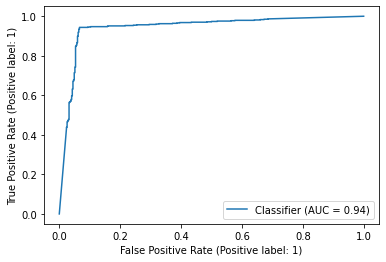

In [47]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_true, y_pred, ax = ax)
fig.savefig('roc_curves/LGBM_next_step.png')

Pick the best threshold value suggested by this result

In [108]:
best_threshold(y_true, y_pred)

Best Threshold = 0.916857, G-Mean = 0.939


In [33]:
y_avg_true = []
y_avg_pred = []
for st in startpts:
    sleep = data.iloc[st : st + 60 * 24 * 6, [kidn, -4, -3, -2, -1]]
    sleep = sleep.rename(columns={str(kidn-1): 'sleep'})
    y_avg_true += [data.iloc[st + 60 * 24 * 6, kidn]]
    y_avg_pred += [LGBMavg.predict_proba(sleep)]

Best Threshold = 0.527559, G-Mean = 0.872


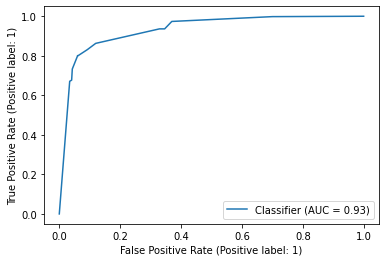

In [44]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_avg_true, y_avg_pred, ax = ax)
fig.savefig('roc_curves/LGBM_avg.png')
best_threshold(y_avg_true, y_avg_pred)

### SARIMAX model ROC curve
An equivalent evaluation of the performance of the SARIMAX model will be much more time-consuming. This is primarily due to how heavy SARIMAX model with 144-step period is.
Therefore, instead of using the random sampling of time periods as above, I will first train the model on the period between 110 and 120 days and then construct a sequence of NUMBER 1-step predictions each time updating SARIMAX model with new data, but without re-evaluating parameters of the model.

In [14]:
sleep = data.iloc[70 * 24 * 6 : 130 * 24 * 6, [kidn, -4, -3, -2, -1]]
sleep = sleep.rename(columns={str(kidn-1): 'sleep'})
time0 = pd.to_datetime('11/11/2022')

In [15]:
SARIMAXfc.model_update(sleep, time0, '')

begin update


/Users/olegdubinkin/Documents/Python/PyCharm/BabySleep/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
/Users/olegdubinkin/Documents/Python/PyCharm/BabySleep/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24301D-01    |proj g|=  8.99865D-01

At iterate    5    f=  9.39559D-02    |proj g|=  1.08774D-01

At iterate   10    f=  8.93616D-02    |proj g|=  1.48513D-01

At iterate   15    f=  6.81085D-02    |proj g|=  5.14347D-01

At iterate   20    f=  5.11189D-02    |proj g|=  4.33297D-03

At iterate   25    f=  5.09936D-02    |proj g|=  2.04386D-03

At iterate   30    f=  5.09765D-02    |proj g|=  1.74775D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

FileExistsError: [Errno 17] File exists: 'saved_models/SARIMAX_time.txt'

In [18]:
%%time
y_sm_true = []
y_sm_pred = []
npts = 1
for st in (70 * 24 * 6 + 1, 70 * 24 * 6 + 1 + npts):
    sleep = data.iloc[st : st + 60 * 24 * 6, [kidn, -4, -3, -2, -1]]
    sleep = sleep.rename(columns={str(kidn-1): 'sleep'})
    y_sm_true += [data.iloc[st + 60 * 24 * 6, kidn]]
    y_sm_pred += [SARIMAXfc.predict_proba(sleep, DATA_PATH, '')]

CPU times: user 6min 19s, sys: 4min 51s, total: 11min 10s
Wall time: 4min 2s


In [ ]:
RocCurveDisplay.from_predictions(y_sm_true, y_sm_pred)

This evaluation will take quite a long time, I will leave it out for now...

### 2. ROC Curves for tough examples
Finally, let us consider the examples which are probably the toughest ones to classify correctly. The analysis done above most likely was dominated by examples where the baby's sleep state in the next step was the same as the state in the previous step. Our models, most likely, fail most often when they have to make a decision to change the status from 'sleep' to 'awake' or vice-versa. We can confirm it by calculating the ROC curve for such tough examples. However, in practice we see that our models are perfectly capable to forecast periods of sleep and wakeness. The evaluation below simply reflects the fact that our models can't capture the moment of falling asleep precisely enough.

In [35]:
toughpts = []
for st in range(start, end):
    if data.iloc[st + 60 * 24 * 6 - 1, kidn] != data.iloc[st + 60 * 24 * 6, kidn]:
        toughpts += [st]

In [91]:
y_true_th = []
y_pred_th = []
for st in toughpts:
    sleep = data.iloc[st : st + 60 * 24 * 6, [kidn, -4, -3, -2, -1]]
    sleep = sleep.rename(columns={str(kidn-1): 'sleep'})
    y_true_th += [data.iloc[st + 60 * 24 * 6, kidn]]
    y_pred_th += [LGBM1step.predict_proba(sleep, DATA_PATH)]

NameError: name 'y_true_th' is not defined

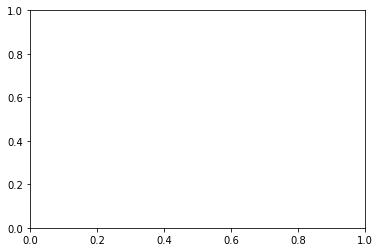

In [42]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_true_th, y_pred_th, ax = ax)
fig.savefig('roc_curves/LGBM_next_step_th.png')

In [38]:
y_avg_true_th = []
y_avg_pred_th = []
for st in toughpts:
    sleep = data.iloc[st : st + 60 * 24 * 6, [kidn, -4, -3, -2, -1]]
    sleep = sleep.rename(columns={str(kidn-1): 'sleep'})
    y_avg_true_th += [data.iloc[st + 60 * 24 * 6, kidn]]
    y_avg_pred_th += [LGBMavg.predict_proba(sleep)]

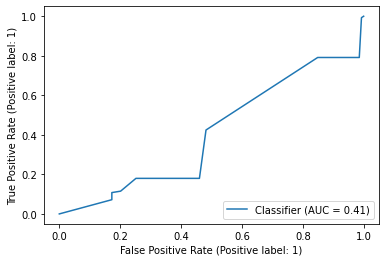

In [43]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_avg_true_th, y_avg_pred_th, ax = ax)
fig.savefig('roc_curves/LGBM_avg_th.png')

# Evaluating models' performance forecasting 24 hours of sleep/awake states
Here we will evaluate our model's performance when predicting a 24 hours of sleep/awake states.

In [167]:
def forecast_eval(data, sleep_pred):
    '''
    custom function scoring sleep forecast

    :param data: NYU processed dataset
    :param sleep_pred: sleep forecast returned by one of the models in our package
    :return: a model score between 0 (worst) and 1 (best)
    '''

    sleep = data.iloc[:, [kidn]]
    sleep = sleep.rename(columns={str(kidn-1): 'sleep'})
    conv = np.array([1, 1, 2, 3, 6, 3, 2, 1, 1]) / 20
    sleep_pred_sm = pred_proc.smooth(sleep_pred, conv, 64)[64:]

    sleep = sleep.sleep[sleep.index >= sleep_pred_sm.index[0]]
    sleep = pd.DataFrame(sleep[sleep.index <= sleep_pred_sm.index[-1]])

    day_score = 1 - abs((sleep.values - sleep_pred_sm.values)).sum() / sleep_pred_sm.values.shape[0]

    return day_score

In [169]:
kidn = 10
st = 130 * 24 * 6
en = st + 60 * 24 * 6
forecast_period = 24 * 6 + 10

In [170]:
scores_avg = []
for st in startpts:
    en = st + 60 * 24 * 6
    sleep = data.iloc[st : en, [kidn, -4, -3, -2, -1]]
    sleep = sleep.rename(columns={str(kidn-1): 'sleep'})
    sleep_pred = LGBMavg.forecast(sleep, sleep.index[-1], forecast_period)
    scores_avg += [forecast_eval(data, sleep_pred)]

In [ ]:
scores_1step = []
for st in startpts:
    en = st + 60 * 24 * 6
    sleep = data.iloc[st : en, [kidn, -4, -3, -2, -1]]
    sleep = sleep.rename(columns={str(kidn-1): 'sleep'})
    sleep_pred = LGBM1step.forecast(sleep, sleep.index[-1], '../../data/', forecast_period)
    scores_1step += [forecast_eval(data, sleep_pred)]

0.8075342465753425
CPU times: user 4min 30s, sys: 8.81 s, total: 4min 39s
Wall time: 22.4 s


<AxesSubplot:xlabel='timestamps'>

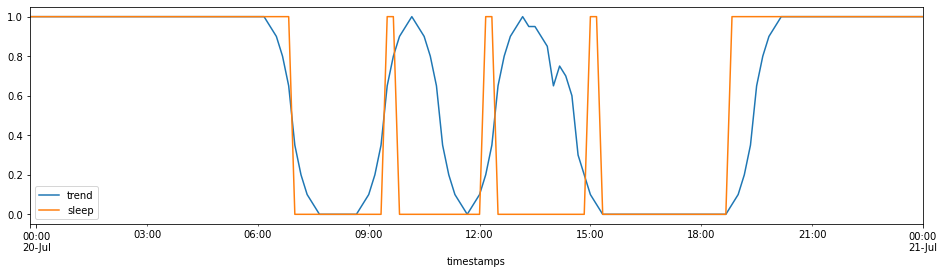

In [165]:
%%time

kidn = 10
st = 141 * 24 * 6
en = st + 60 * 24 * 6
forecast_period = 24 * 6 + 10
sleep = data.iloc[st : en, [kidn, -4, -3, -2, -1]]
sleep = sleep.rename(columns={str(kidn-1): 'sleep'})

#sleep_pred = LGBMavg.forecast(sleep, sleep.index[-1], forecast_period)
sleep_pred = LGBM1step.forecast(sleep, sleep.index[-1], '../../data/', forecast_period)

def forecast_eval_test(data, sleep_pred):
    sleep = data.iloc[:, [kidn]]
    sleep = sleep.rename(columns={str(kidn-1): 'sleep'})
    conv = np.array([1, 1, 2, 3, 6, 3, 2, 1, 1]) / 20
    sleep_pred_sm = pred_proc.smooth(sleep_pred, conv, 64)[64:]

    sleep = sleep.sleep[sleep.index >= sleep_pred_sm.index[0]]
    sleep = pd.DataFrame(sleep[sleep.index <= sleep_pred_sm.index[-1]])

    day_score = 1 - abs((sleep.values - sleep_pred_sm.values)).sum() / sleep_pred_sm.values.shape[0]

    return sleep, sleep_pred_sm, day_score

sltr, slpr, scr = forecast_eval_test(data, sleep_pred)
print(scr)
fig, ax = plt.subplots(figsize=(16, 4))
slpr.plot(ax = ax)
sltr.plot(ax = ax)